## Spam Email Classifier with KNN using TF-IDF scores

1.   Assignment must be implemented in Python 3 only.
2.   You are allowed to use libraries for data preprocessing (numpy, pandas, nltk etc) and for evaluation metrics, data visualization (matplotlib etc.).
3.   You will be evaluated not just on the overall performance of the model and also on the experimentation with hyper parameters, data prepossessing techniques etc.
4.   The report file must be a well documented jupyter notebook, explaining the experiments you have performed, evaluation metrics and corresponding code. The code must run and be able to reproduce the accuracies, figures/graphs etc.
5.   For all the questions, you must create a train-validation data split and test the hyperparameter tuning on the validation set. Your jupyter notebook must reflect the same.
6.   Strict plagiarism checking will be done. An F will be awarded for plagiarism.

**Task: Given an email, classify it as spam or ham**

Given input text file ("emails.txt") containing 5572 email messages, with each row having its corresponding label (spam/ham) attached to it.

This task also requires basic pre-processing of text (like removing stopwords, stemming/lemmatizing, replacing email_address with 'email-tag', etc..).

You are required to find the tf-idf scores for the given data and use them to perform KNN using Cosine Similarity.

### Import necessary libraries

In [ ]:
!pip install nltk
!pip install num2words
!pip install tabulate
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import nltk
import re
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
stop_words=set(stopwords.words("english"))
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
stem = PorterStemmer()
from nltk.stem.wordnet import WordNetLemmatizer
lem = WordNetLemmatizer()
from num2words import num2words
from scipy.spatial.distance import cityblock
from sklearn.metrics import accuracy_score
from numpy import dot
from numpy.linalg import norm
import json
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tabulate import tabulate
import time

     |████████████████████████████████| 101 kB 3.9 MB/s 
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


### Preprocess data

In [ ]:
def repalce_numbers(line):
  """function replaces numbers with phone number tag and converts small numbers in to words"""
  new_line = ""
  for word in line.split():
    if word.isnumeric():
      if len(word) < 7:
        new_line += num2words(word)
        new_line += ' '
      else:
        new_line += "phonenumber"
    else:
      new_line += word
      new_line += ' '
  return new_line

In [ ]:
def email_tagging(line):
  """function for email tagging"""
  new_line = ""
  regex = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'
  for word in line.split():
    if (re.fullmatch(regex,word)):
      new_line += "emailtag"
      new_line += ' '
    else:
      new_line += word
      new_line += ' '
  return new_line

In [ ]:
def remove_stopwords(line):
  """function to remove stopwords"""
  filtered_line = []
  for word in line:
    if word not in stop_words:
      filtered_line.append(word)
  return filtered_line

In [ ]:
def remove_single_chars(line):
  """function to remove single characters"""
  filtered_line = []
  for word in line:
    if len(word) > 1:
      filtered_line.append(word)
  return filtered_line

In [ ]:
def stemming(line):
  """function for stemming"""
  stemmed_line = []
  for word in line:
    stemmed_line.append(stem.stem(word))
  return stemmed_line

In [ ]:
def lemmatizer(line):
  """function for lemmatizing words"""
  lemmatized_line = []
  for word in line:
    new_word = lem.lemmatize(word)
    lemmatized_line.append(new_word)
    # if new_word != word:
    #   print("word:",word," new_word:",new_word)
  return lemmatized_line

In [ ]:
def replace_alphanumeric(line):
  """to remove alpha-numeric words"""
  new_line = ""
  s=0
  for word in line.split():
    if word.isnumeric() == False and word.isalpha()==False:
      #do_nothing!
      s += 1
    else:
      new_line += word
      new_line += ' '
  return new_line

In [ ]:
def create_dict(text):
  """creating vocabulary from corpus"""
  dict = {}
  for line in text:
    for word in line:
      if word in dict:
        dict[word] += 1
      else:
        dict[word] = 1
  return dict;

In [ ]:
def get_vector(dict,text):
  """For calculating term-frequency"""
  X = []
  for line in text:
    vec = []
    dict_line = {}
    for word in line:
      if word in  dict_line:
        dict_line[word] += 1
      else:
        dict_line[word] = 1
    for word in dict.keys():
      if word in dict_line.keys():
        vec.append(dict_line[word]/len(line))
      else:
        vec.append(0)
    X.append(vec)
  return X

In [ ]:
def create_df(dict,text):
  """for calculating document frequency"""
  df=[0 for i in range(len(list(dict.keys())))]
  i = -1
  for word in dict.keys():
    i += 1
    for line in text:
      if word in line:
        df[i] += 1
  return df

def idf(df,text):
  """for calculating inverse document frequency
  idf = np.log(N/(df+1))"""
  idf = []
  for i in df:
    idf.append(np.log(len(text)/(df[i]+1)))
  return idf

def tf_idf(x,idf):
  """for calculating tf-idf"""
  for vec in x:
    for i in range(len(idf)):
      vec[i] = vec[i] * idf[i]
    #ven = vec / norm(vec)   
  return x

In [ ]:
def drop_dup(text):
  """for droping duplicates"""
  clean_text = pd.DataFrame(text)
  #print("before droping:",len(text))
  clean_text.drop_duplicates(inplace=True)
  #print("df_frame:",len(clean_text))
  return clean_text

In [ ]:
def preprocess(filename):
  """Main function for complete Preprocessing using earlier defined functions"""
  file = open(filename,'r')
  text = []
  for line in file:
    line = repalce_numbers(line)
    line = email_tagging(line)
    #line = replace_alphanumeric(line)
    line = re.sub(r"[^a-z0-9]", " ", line.lower())
    if line.split() not in text:
      text.append(line.split())
  file.close()
  y1 = []
  for i in range(len(text)):
    if text[i][0] == 'spam':
      y1.append(1)
    elif text[i][0] == 'ham':
      y1.append(0)
    text[i].pop(0)
  processed_text = []
  index = 0
  y = []
  line_length = []
  for line in text:
    line = remove_stopwords(line)
    line = remove_single_chars(line)
    #line = stemming(line)
    line = lemmatizer(line)
    if len(line) > 0:
      processed_text.append(line)
      line_length.append(len(line))
      y.append(y1[index])
    index += 1
  text.clear()
  y1.clear()
  # processed_text = drop_dup(processed_text)
  #processed_text.values.tolist()
  # print(processed_text.shape)
  # print(processed_text.head())
  vocab = create_dict(processed_text)
  #print("vocab length:", len(vocab))
  tf = get_vector(vocab,processed_text)
  df = create_df(vocab,processed_text)
  idf_ = idf(df,processed_text)
  x = tf_idf(tf,idf_)
  return x,y,line_length

### Load dataset

In [ ]:
"""calling pre-processing function!"""
data = preprocess('/content/emails.txt')

In [ ]:
print(len(data[0]),len(data[0][0]))
print(len(data[1]),data[1])
print(len(data[2]))

5108 7775
5108 [0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 

### Split data

In [ ]:
df_x = np.array(data[0])
df_y = np.array(data[1])
line_lengths = data[2]

In [ ]:
del data

In [ ]:
print("x shape:" , np.shape(df_x))
print("y shape:" , np.shape(df_y))

x shape: (5108, 7775)
y shape: (5108,)


In [ ]:
"""splitting data in traning set, valid set and testing set"""
x_train, x, y_train, y = train_test_split(df_x, df_y, test_size=0.3, random_state=35)
x_valid, x_test, y_valid, y_test = train_test_split(x, y, test_size=0.33, random_state=36)
del df_x
del df_y
del x 
del y

In [ ]:
print(np.shape(x_train),np.shape(y_train))
print(np.shape(x_valid),np.shape(y_valid))
print(np.shape(x_test),np.shape(y_test))

(3575, 7775) (3575,)
(1027, 7775) (1027,)
(506, 7775) (506,)


In [ ]:
def distance_btn(test_node,node,d_type):
  """For calculating distance between two data-points by Distance Method mentioned"""
  #1 Euclindean Distance
  if d_type == 1:
    return np.linalg.norm(test_node - node)
  #2 Manhattan Distance
  elif d_type == 2:
    return cityblock(test_node,node)
  # #3 hamming distance
  # elif d_type == 3:
  #   return cityblock(test_node,node)/len(node)
  #4 cosine distance
  elif d_type == 4:
    cos_sim = 1 - (dot(node,test_node)/(norm(test_node)*norm(node)))
    return cos_sim
  #return cosine_similarity(test_node,node)

In [ ]:
def find_max(dict):
  max = -1;
  for i in dict.keys():
    if i > max:
      max = i
  return max

###Built-from scratch Model

In [ ]:
def kNeighbours(k,x_test,x,y,d_type):
  """Returns k Neighbors dictionary for every datapoint in x_test/x_valid"""
  k_neighbors = []
  for test_node in x_test:
    label_dict = {}
    for i in range(len(x)):
      node = x[i]
      dist = distance_btn(test_node,node,d_type)
      if len(label_dict) < k:
        label_dict[dist] = y[i]
      elif len(label_dict) == k:
        max = find_max(label_dict)
        if max > dist:
          label_dict.pop(max)
          label_dict[dist] = y[i]
    k_neighbors.append(label_dict)
  return k_neighbors

def knn_predict(k_neighbors):
  """Returns prediction list for every datapoint in x_test/x_valid"""
  y_pred = []
  for neighbors in k_neighbors:
    ones = 0
    zeros = 0
    for label in neighbors.values():
      if label == 0:
        zeros += 1
      else:
        ones += 1
    if zeros > ones :
      y_pred.append(0)
    else:
      y_pred.append(1)
  return y_pred

In [ ]:
k_values = [1,3,5,7,11,17,23,28]

In [ ]:
k_euclidean_y_pred = []
for k in k_values:
  neighbors = kNeighbours(k,x_valid,x_train,y_train,1)
  y_valid_pred = knn_predict(neighbors)
  print("k-value:",k,"Accuracy:",accuracy_score(y_valid, y_valid_pred))
  k_euclidean_y_pred.append(y_valid_pred)

k-value: 1 Accuracy: 0.9367088607594937
k-value: 3 Accuracy: 0.9318403115871471
k-value: 5 Accuracy: 0.9250243427458618
k-value: 7 Accuracy: 0.9191820837390458
k-value: 11 Accuracy: 0.9152872444011685
k-value: 17 Accuracy: 0.9172346640701071
k-value: 23 Accuracy: 0.9211295034079844
k-value: 28 Accuracy: 0.9269717624148004


In [ ]:
k_manhattan_y_pred = []
for k in k_values:
  neighbors = kNeighbours(k,x_valid,x_train,y_train,2)
  y_valid_pred = knn_predict(neighbors)
  print("k-value:",k,"Accuracy:",accuracy_score(y_valid, y_valid_pred))
  k_manhattan_y_pred.append(y_valid_pred)

k-value: 1 Accuracy: 0.9668938656280428
k-value: 3 Accuracy: 0.9610516066212269
k-value: 5 Accuracy: 0.9561830574488802
k-value: 7 Accuracy: 0.9464459591041869
k-value: 11 Accuracy: 0.943524829600779
k-value: 17 Accuracy: 0.9367088607594937
k-value: 23 Accuracy: 0.9298928919182083
k-value: 28 Accuracy: 0.9318403115871471


In [ ]:
k_cosine_y_pred = []
for k in k_values:
  neighbors = kNeighbours(k,x_valid,x_train,y_train,4)
  y_valid_pred = knn_predict(neighbors)    
  print("k-value:",k,"Accuracy:",accuracy_score(y_valid, y_valid_pred))
  k_cosine_y_pred.append(y_valid_pred)

k-value: 1 Accuracy: 0.9610516066212269
k-value: 3 Accuracy: 0.9620253164556962
k-value: 5 Accuracy: 0.9639727361246349
k-value: 7 Accuracy: 0.9591041869522883
k-value: 11 Accuracy: 0.9552093476144109
k-value: 17 Accuracy: 0.9503407984420643
k-value: 23 Accuracy: 0.9493670886075949
k-value: 28 Accuracy: 0.9483933787731256


In [ ]:
all_predictions = {}
all_predictions['euclidean'] = k_euclidean_y_pred
all_predictions['manhattan'] = k_manhattan_y_pred
#all_predictions['hamming'] = k_hamming_y_pred
all_predictions['cosine'] = k_cosine_y_pred
print(all_predictions)

{'euclidean': [[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 

In [ ]:
# out_file = open("prediction_data.json", "w")
# json.dump(all_predictions, out_file)
# out_file.close()

In [ ]:
# in_file = open("prediction_data.json", "r")
# all_predictions = json.load(in_file)
# in_file.close()

### Train your KNN model (reuse previously iplemented model built from scratch) and test on your data

In [ ]:
def f1_score(tp,fp,fn):
  return 2*tp / (2*tp + fp + fn)

In [ ]:
def accuracy(values):
  return (values[0]+values[3])/(values.sum())

In [ ]:
def precision(values):
  return (values[0])/(values[0]+values[1])

In [ ]:
def recall(values):
  return (values[0])/(values[0]+values[2])

***1. Experiment with different distance measures [Euclidean distance, Manhattan distance, Hamming Distance] and compare with the Cosine Similarity distance results.***

Metris: Euclidean k_value: 1


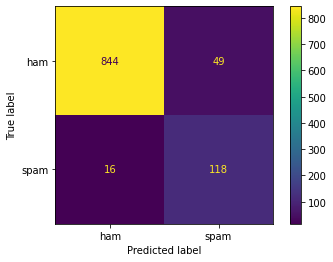

Metris: Euclidean k_value: 3


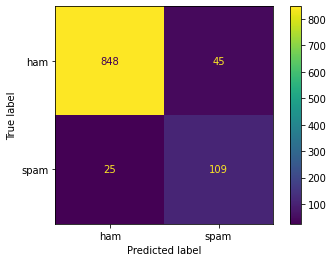

Metris: Euclidean k_value: 5


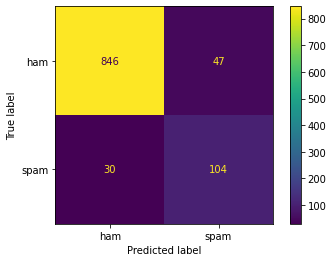

Metris: Euclidean k_value: 7


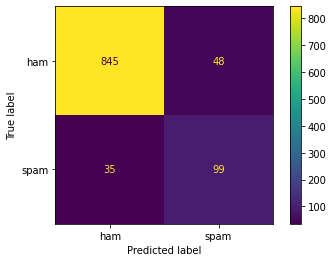

Metris: Euclidean k_value: 11


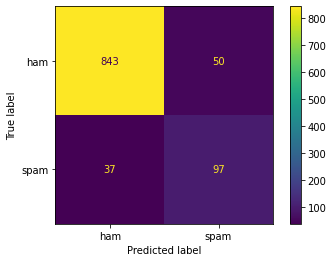

Metris: Euclidean k_value: 17


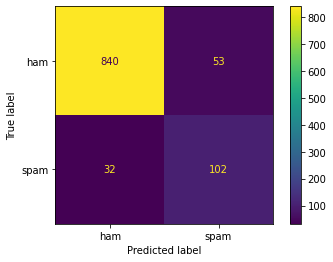

Metris: Euclidean k_value: 23


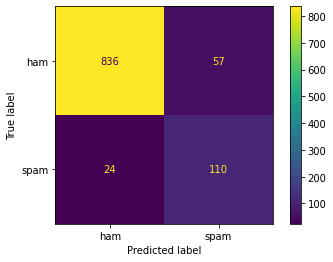

Metris: Euclidean k_value: 28


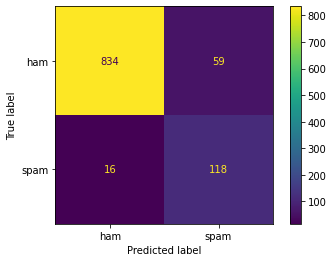

In [ ]:
#tn, fp, fn, tp
f1_euclidean = []
accuracy_euclidean = []
precision_euclidean = []
recall_euclidean = []
for itr in range(len(k_values)):
  predicted = all_predictions['euclidean'][itr]
  values = confusion_matrix(y_valid,predicted)
  disp = ConfusionMatrixDisplay(confusion_matrix=values,display_labels=['ham','spam'])
  print("Metris:","Euclidean","k_value:",k_values[itr])
  disp.plot()
  plt.show()
  values = values.ravel() 
  f1_euclidean.append(f1_score(values[3],values[1],values[2]))
  accuracy_euclidean.append(accuracy(values))
  precision_euclidean.append(precision(values))
  recall_euclidean.append(recall(values))

In [ ]:
print("Euclidean Distance as Metric:")
print("K-Values:",k_values)
print("Accuracy:",accuracy_euclidean)
print("Precision:",precision_euclidean)
print("Recall:",recall_euclidean)
print("F1-score:",f1_euclidean)

Euclidean Distance as Metric:
K-Values: [1, 3, 5, 7, 11, 17, 23, 28]
Accuracy: [0.9367088607594937, 0.9318403115871471, 0.9250243427458618, 0.9191820837390458, 0.9152872444011685, 0.9172346640701071, 0.9211295034079844, 0.9269717624148004]
Precision: [0.9451287793952967, 0.9496080627099664, 0.9473684210526315, 0.9462486002239642, 0.9440089585666294, 0.9406494960806271, 0.9361702127659575, 0.9339305711086227]
Recall: [0.9813953488372092, 0.9713631156930126, 0.9657534246575342, 0.9602272727272727, 0.9579545454545455, 0.963302752293578, 0.9720930232558139, 0.9811764705882353]
F1-score: [0.7840531561461794, 0.7569444444444444, 0.7298245614035088, 0.7046263345195729, 0.6903914590747331, 0.7058823529411765, 0.7308970099667774, 0.7588424437299035]


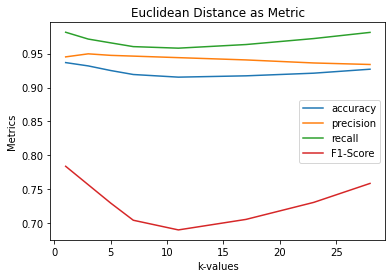

In [ ]:
plt.plot(k_values,accuracy_euclidean,label = 'accuracy')
plt.plot(k_values,precision_euclidean,label = 'precision')
plt.plot(k_values,recall_euclidean,label = 'recall')
plt.plot(k_values,f1_euclidean,label = 'F1-Score')
plt.legend()
plt.ylabel("Metrics")
plt.xlabel("k-values")
plt.title("Euclidean Distance as Metric")
plt.show()

Metris: Manhattan k_value: 1


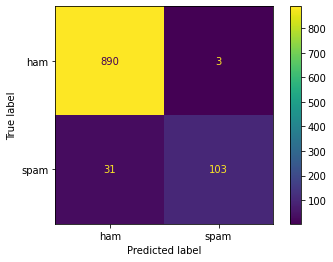

Metris: Manhattan k_value: 3


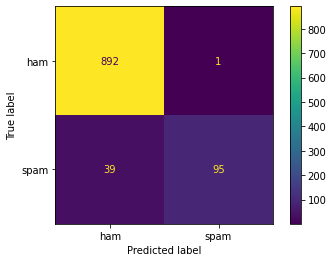

Metris: Manhattan k_value: 5


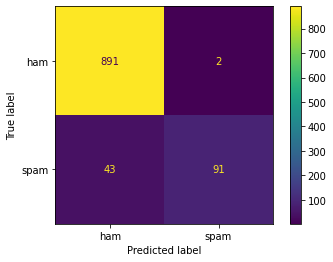

Metris: Manhattan k_value: 7


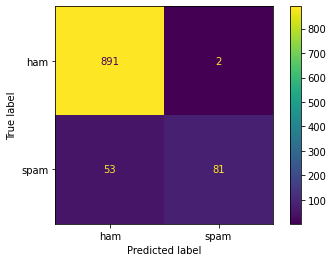

Metris: Manhattan k_value: 11


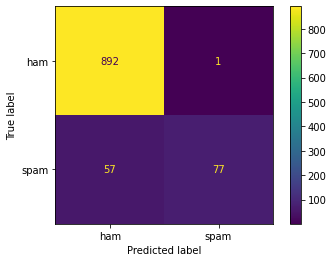

Metris: Manhattan k_value: 17


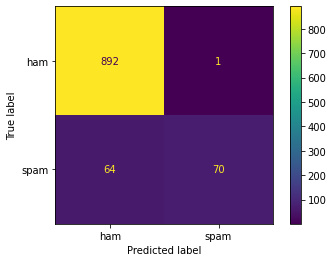

Metris: Manhattan k_value: 23


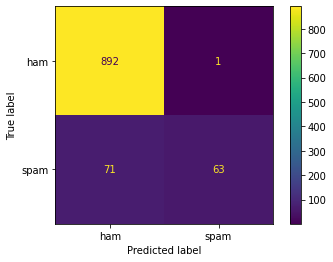

Metris: Manhattan k_value: 28


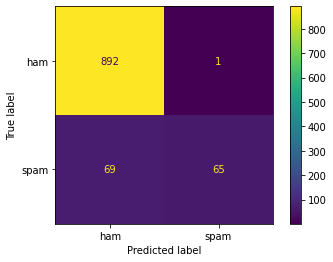

In [ ]:
f1_manhattan = []
accuracy_manhattan = []
precision_manhattan = []
recall_manhattan = []
for itr in range(len(k_values)):
  predicted = all_predictions['manhattan'][itr]
  values = confusion_matrix(y_valid,predicted)
  disp = ConfusionMatrixDisplay(confusion_matrix=values,display_labels=['ham','spam'])
  print("Metris:","Manhattan","k_value:",k_values[itr])
  disp.plot()
  plt.show()
  values = values.ravel()
  f1_manhattan.append(f1_score(values[3],values[1],values[2]))
  accuracy_manhattan.append(accuracy(values))
  precision_manhattan.append(precision(values))
  recall_manhattan.append(recall(values))

In [ ]:
print("Manhattan Distance as Metric:")
print("K-Values:",k_values)
print("Accuracy:",accuracy_manhattan)
print("Precision:",precision_manhattan)
print("Recall:",recall_manhattan)
print("F1-score:",f1_manhattan)

Manhattan Distance as Metric:
K-Values: [1, 3, 5, 7, 11, 17, 23, 28]
Accuracy: [0.9668938656280428, 0.9610516066212269, 0.9561830574488802, 0.9464459591041869, 0.943524829600779, 0.9367088607594937, 0.9298928919182083, 0.9318403115871471]
Precision: [0.9966405375139977, 0.9988801791713325, 0.9977603583426652, 0.9977603583426652, 0.9988801791713325, 0.9988801791713325, 0.9988801791713325, 0.9988801791713325]
Recall: [0.9663409337676439, 0.958109559613319, 0.9539614561027837, 0.9438559322033898, 0.9399367755532139, 0.9330543933054394, 0.9262720664589823, 0.9281997918834547]
F1-score: [0.8583333333333333, 0.8260869565217391, 0.801762114537445, 0.7465437788018433, 0.7264150943396226, 0.6829268292682927, 0.6363636363636364, 0.65]


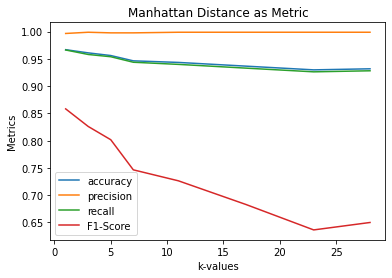

In [ ]:
plt.plot(k_values,accuracy_manhattan,label = 'accuracy')
plt.plot(k_values,precision_manhattan,label = 'precision')
plt.plot(k_values,recall_manhattan,label = 'recall')
plt.plot(k_values,f1_manhattan,label = 'F1-Score')
plt.legend()
plt.ylabel("Metrics")
plt.xlabel("k-values")
plt.title("Manhattan Distance as Metric")
plt.show()

Metris: Cosine k_value: 1


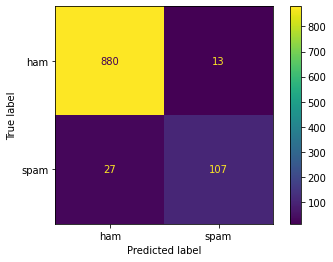

Metris: Cosine k_value: 3


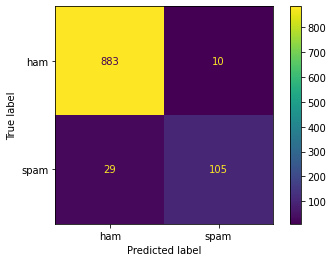

Metris: Cosine k_value: 5


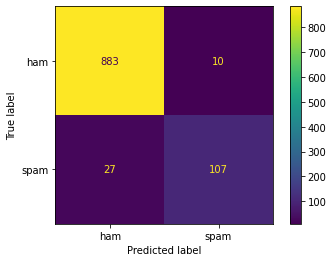

Metris: Cosine k_value: 7


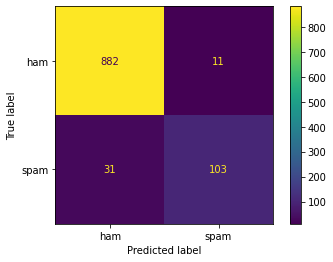

Metris: Cosine k_value: 11


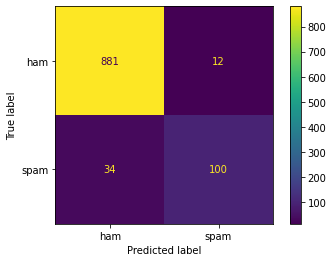

Metris: Cosine k_value: 17


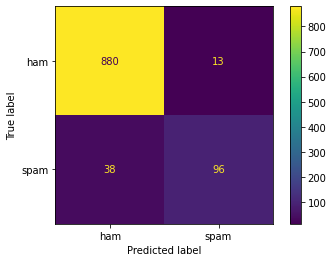

Metris: Cosine k_value: 23


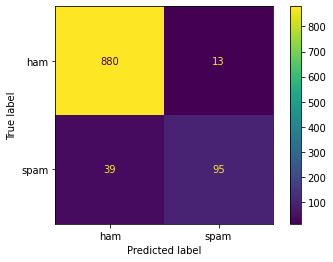

Metris: Cosine k_value: 28


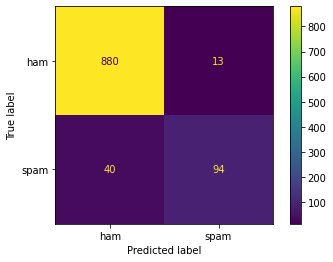

In [ ]:
f1_cosine = []
accuracy_cosine = []
precision_cosine = []
recall_cosine = []
for itr in range(len(k_values)):
  predicted = all_predictions['cosine'][itr]
  values = confusion_matrix(y_valid,predicted)
  disp = ConfusionMatrixDisplay(confusion_matrix=values,display_labels=['ham','spam'])
  print("Metris:","Cosine","k_value:",k_values[itr])
  disp.plot()
  plt.show()
  values = values.ravel()
  f1_cosine.append(f1_score(values[3],values[1],values[2]))
  accuracy_cosine.append(accuracy(values))
  precision_cosine.append(precision(values))
  recall_cosine.append(recall(values))

In [ ]:
print("Cosine Distance as Metric:")
print("K-Values:",k_values)
print("Accuracy:",accuracy_cosine)
print("Precision:",precision_cosine)
print("Recall:",recall_cosine)
print("F1-score:",f1_cosine)

Cosine Distance as Metric:
K-Values: [1, 3, 5, 7, 11, 17, 23, 28]
Accuracy: [0.9610516066212269, 0.9620253164556962, 0.9639727361246349, 0.9591041869522883, 0.9552093476144109, 0.9503407984420643, 0.9493670886075949, 0.9483933787731256]
Precision: [0.9854423292273237, 0.9888017917133258, 0.9888017917133258, 0.9876819708846585, 0.986562150055991, 0.9854423292273237, 0.9854423292273237, 0.9854423292273237]
Recall: [0.9702315325248071, 0.9682017543859649, 0.9703296703296703, 0.9660460021905805, 0.9628415300546448, 0.9586056644880174, 0.9575625680087051, 0.9565217391304348]
F1-score: [0.84251968503937, 0.8433734939759037, 0.852589641434263, 0.8306451612903226, 0.8130081300813008, 0.7901234567901234, 0.7851239669421488, 0.7800829875518672]


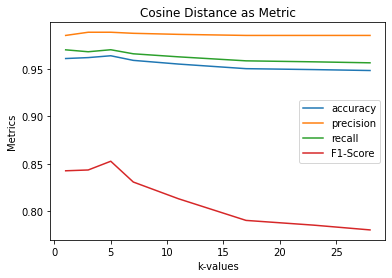

In [ ]:
plt.plot(k_values,accuracy_cosine,label = 'accuracy')
plt.plot(k_values,precision_cosine,label = 'precision')
plt.plot(k_values,recall_cosine,label = 'recall')
plt.plot(k_values,f1_cosine,label = 'F1-Score')
plt.legend()
plt.ylabel("Metrics")
plt.xlabel("k-values")
plt.title("Cosine Distance as Metric")
plt.show()

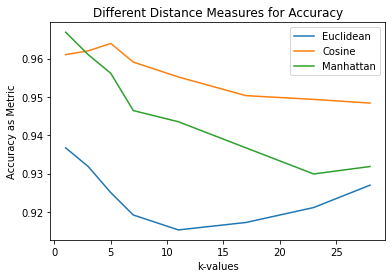

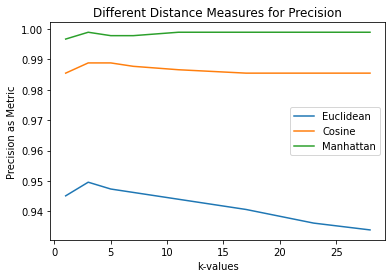

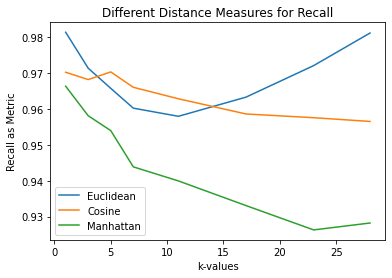

In [ ]:
plt.plot(k_values,accuracy_euclidean,label = 'Euclidean')
plt.plot(k_values,accuracy_cosine,label = 'Cosine')
plt.plot(k_values,accuracy_manhattan,label = 'Manhattan')
plt.legend()
plt.ylabel("Accuracy as Metric")
plt.xlabel("k-values")
plt.title("Different Distance Measures for Accuracy")
print()
plt.show()

plt.plot(k_values,precision_euclidean,label = 'Euclidean')
plt.plot(k_values,precision_cosine,label = 'Cosine')
plt.plot(k_values,precision_manhattan,label = 'Manhattan')
plt.legend()
plt.ylabel("Precision as Metric")
plt.xlabel("k-values")
plt.title("Different Distance Measures for Precision")
plt.show()

plt.plot(k_values,recall_euclidean,label = 'Euclidean')
plt.plot(k_values,recall_cosine,label = 'Cosine')
plt.plot(k_values,recall_manhattan,label = 'Manhattan')
plt.legend()
plt.ylabel("Recall as Metric")
plt.xlabel("k-values")
plt.title("Different Distance Measures for Recall")
plt.show()

***2. Explain which distance measure works best and why? Explore the distance measures and weigh their pro and cons in different application settings.***

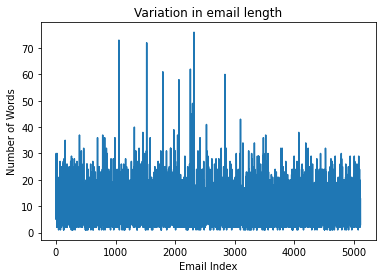

In [ ]:
indices = [i for i in range(1,len(line_lengths)+1)]
plt.plot(indices,line_lengths,label = 'Email length')
#plt.legend()
plt.ylabel("Number of Words")
plt.xlabel("Email Index")
plt.title("Variation in email length")
plt.show()

We can see from the above plotted graphs, 
*    Cosine has better Accuracy, Precision, Recall and F1-score when compared with other distance metrics overall.
*    Cosine Distance calculates the angle between two vectors irrespective with the length of vectors. Whereas Euclidean and Manhattan distance takes the length of text while calculating similarity between documents.
*    Moreover, as the dimensionality of your data grows, the Euclidean distance will become less informative. This has to do with the curse of dimensionality, which refers to the fact that higher-dimensional space behaves differently from 2D or 3D space
*    In Manhattan Distance, it does not take the shortest path, it is more likely to return a higher distance value than euclidean distance so we can't rely on that in this particular case.
*    Two documents with different length can be similar, we can observe that only with cosine similarity.

**3.for evaluating model, show confusion matrix, accuracy, recall, precision and F1-score. Answer why accuracy alone is not sufficient to evaluate the model. Why we need precision/recall/f1-score**

In [ ]:
print("spam count:",np.count_nonzero(y_train) + np.count_nonzero(y_valid) + np.count_nonzero(y_test))
print("Ham count:",len(y_train)+len(y_test)+len(y_valid) - (np.count_nonzero(y_train) + np.count_nonzero(y_valid) + np.count_nonzero(y_test)))

spam count: 617
Ham count: 4491


*   **Accuracy** is the total number of correctly labeled instances to that of all the instances. Either It may be Negitive or Positive
*   Accurancy is Good measure when we have balanced dataset, when we have 
labels evenly. In the emails.txt data provided, we have only 13-14% spam labels only. so even when we have accuracy 90% then also classfier can predict all spam as ham.
*   **Recall**: Out of all emails that are actually spam, how many emails have you identified as spam 
*   **Precision**: out of all emails you identified as spam, how many are actually spam
*   **F1-score**: It is a balanced measure between both precision and recall.
*   We can classify an email as ham even when it is actuall spam, but you have to classify a ham email as spam because we missout an important ham email in to spam bin. So Precision in the good metric.
*   we can use both precision and recall or F1-score as it is balanced by both metrics






***4. Choose different K values (k=1,3,5,7,11,17,23,28) and experiment. Plot a graph values of "K" VS F1-score.***

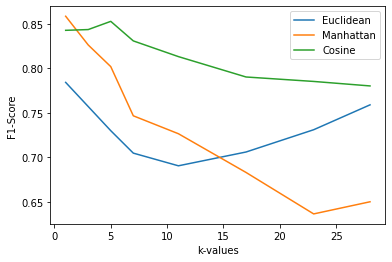

In [ ]:
plt.plot(k_values,f1_euclidean,label = 'Euclidean')
plt.plot(k_values,f1_manhattan,label = 'Manhattan')
plt.plot(k_values,f1_cosine,label = 'Cosine')
# plt.plot(k_values,f1_hamming,label = 'Hamming')
plt.legend()
plt.ylabel("F1-Score")
plt.xlabel("k-values")
plt.show()

*Cosine Distance measure has highest F1-score at k=5 value*

### Train and test Sklearn's KNN classifier model on your data (use metric which gave best results on your experimentation with built-from-scratch model.)

Accuracy: 0.9659201557935735
Vannilla KNN Accuracy: 0.9620253164556962
F1-score: 0.8594377510040161
Vannilla KNN F1-score: 0.8433734939759037
Recall: 0.9703947368421053
Vannilla KNN Recall: 0.9682017543859649
Precision: 0.9910414333706606
Vannilla KNN Precision: 0.9888017917133258


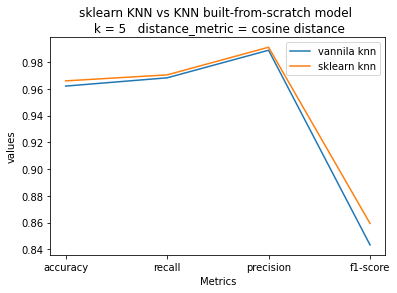

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=5, metric = 'cosine',algorithm='brute')
model.fit(x_train,y_train)
y_pred_skl= model.predict(x_valid)
values = confusion_matrix(y_valid,y_pred_skl).ravel()
print("Accuracy:",accuracy(values))
print("Vannilla KNN Accuracy:",accuracy_cosine[1])
print("F1-score:",f1_score(values[3],values[1],values[2]))
print("Vannilla KNN F1-score:",f1_cosine[1])
print("Recall:",recall(values))
print("Vannilla KNN Recall:",recall_cosine[1])
print("Precision:",precision(values))
print("Vannilla KNN Precision:",precision_cosine[1])
mertics = ["accuracy","recall","precision","f1-score"]
vannila_knn = [accuracy_cosine[1],recall_cosine[1],precision_cosine[1],f1_cosine[1]]
knn = [accuracy(values),recall(values),precision(values),f1_score(values[3],values[1],values[2])]
plt.plot(mertics,vannila_knn,label = 'vannila knn')
plt.plot(mertics,knn,label = 'sklearn knn')
plt.legend()
plt.ylabel("values")
plt.xlabel("Metrics")
plt.title("sklearn KNN vs KNN built-from-scratch model \n k = 5   distance_metric = cosine distance")
plt.show()

**After Exploring all the distance metrics and k_value tunning on validiation data**
*    Running model-built-from scratch on x_test data for k_value = 5 and distance measure is cosine distance

+-----------+----------+
| Metric    |    Score |
+===========+==========+
| F1-score  | 0.8      |
+-----------+----------+
| Accuracy  | 0.960474 |
+-----------+----------+
| Precision | 0.993318 |
+-----------+----------+
| Recall    | 0.963283 |
+-----------+----------+


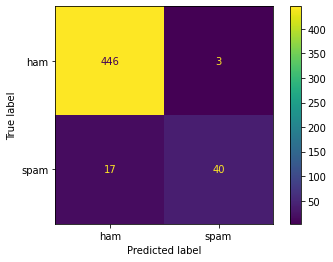

In [ ]:
test_neighbors = kNeighbours(5,x_test,x_train,y_train,4)
y_pred_test = knn_predict(test_neighbors)
values = confusion_matrix(y_test,y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=values,display_labels=['ham','spam'])
disp.plot()
values = values.ravel()
table = [["F1-score",f1_score(values[3],values[1],values[2])],["Accuracy",accuracy(values)],["Precision",precision(values)],["Recall",recall(values)]]
headers = ["Metric", "Score"]
print(tabulate(table, headers, tablefmt="grid"))

+-----------+---------------------+-----------------+
| Metric    |   Vannila KNN Score |   Sklearn Model |
+===========+=====================+=================+
| F1-score  |            0.8      |        0.816327 |
+-----------+---------------------+-----------------+
| Accuracy  |            0.960474 |        0.964427 |
+-----------+---------------------+-----------------+
| Precision |            0.993318 |        0.997773 |
+-----------+---------------------+-----------------+
| Recall    |            0.963283 |        0.963441 |
+-----------+---------------------+-----------------+


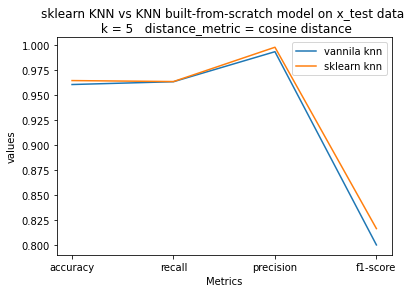

In [ ]:
model_test = KNeighborsClassifier(n_neighbors=5, metric = 'cosine',algorithm='brute')
model_test.fit(x_train,y_train)
y_test_pred_skl= model.predict(x_test)
values_sk = confusion_matrix(y_test,y_test_pred_skl).ravel()

table = [["F1-score",f1_score(values[3],values[1],values[2]),f1_score(values_sk[3],values_sk[1],values_sk[2])],["Accuracy",accuracy(values),accuracy(values_sk)],["Precision",precision(values),precision(values_sk)],["Recall",recall(values),recall(values_sk)]]
headers = ["Metric", "Vannila KNN Score","Sklearn Model"]
print(tabulate(table, headers, tablefmt="grid"))

mertics = ["accuracy","recall","precision","f1-score"]
vannila_knn = [accuracy(values),recall(values),precision(values),f1_score(values[3],values[1],values[2])]
knn = [accuracy(values_sk),recall(values_sk),precision(values_sk),f1_score(values_sk[3],values_sk[1],values_sk[2])]
plt.plot(mertics,vannila_knn,label = 'vannila knn')
plt.plot(mertics,knn,label = 'sklearn knn')
plt.legend()
plt.ylabel("values")
plt.xlabel("Metrics")
plt.title("sklearn KNN vs KNN built-from-scratch model on x_test data \n k = 5   distance_metric = cosine distance")
plt.show()

***What is the time complexity of training using KNN classifier?***

Training Time Complexity: O(1)

***What is the time complexity while testing? Is KNN a linear classifier or can it learn any boundary?***

Training Dataset: **nd**

*  n training datapoints 
*  d number of components(dimensionality) in each data point
##   *Time Complexity for each teat case:* **O(ndk)**
where k is number of neighbors

**KNN is not a linear classifier and learns no boundary**
*   It depends on the neighbors around the test point. 
*   If for a test datapoint all the k neighbors can be very near or totally far. It depends on the instance of the test datapoint.